In [1]:
"""Source : https://www.kaggle.com/ilyamich/mfcc-implementation-and-tutorial"""

"""os library provides a portable way of using operating system dependent functionality."""
import os

"""numpy library contains fundamental package for scientific computing with Python."""
import numpy as np

"""It provides many user-friendly and efficient numerical routines, such as routines for numerical integration, interpolation, 
  optimization, linear algebra, and statistics."""
import scipy

"""wavefile library provides the methods to read and get information from the wav files."""
from scipy.io import wavfile

"""Return discrete Fourier transform of real or complex sequence."""
import scipy.fftpack as fft

"""get_window: Return a window of a given length and type."""
from scipy.signal import get_window

"""Public API for display tools in IPython."""
import IPython.display as ipd

"""Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python."""
import matplotlib.pyplot as plt

"""%matplotlib inline command will make plots outputs appear in the notebook"""
%matplotlib inline

In [2]:
# audio file path
inputAudio = 'Train/1/1-adithya.wav'

# displaying the audio
ipd.Audio(inputAudio)

In [27]:
# reading the wav file and getting sample rate and audio data
sample_rate, audio = wavfile.read(inputAudio)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 8000Hz
Audio duration: 1.996875s


In [28]:
# audio normalizing function so that the audio values will be between -1 to 1
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

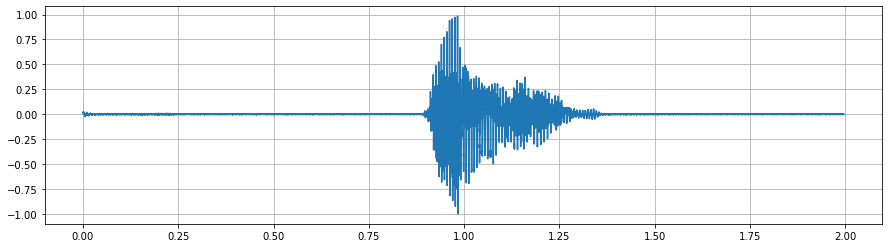

In [5]:
# normalizing the audio data
audio = normalize_audio(audio)

# plotting the normalized audio data normalize for ranges to easy to analyze
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

#### Audio Framing

In [6]:
# audio framing fuction to devide the signal into short frames
# hop_size: number of samples between each successive FFT window
# FFT_size: number of bins used for dividing the window into equal strips, or bins

def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [7]:
# setting the frame_audio parameters
hop_size = 25 #ms
FFT_size = 2048

# framed audio matrix with the size of frame number X FFT size
# framing the signal we assured the audio to be periodic.
audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))


Framed audio shape: (80, 2048)


In [8]:
# printing the first frame of framed audio
print("First frame:")
audio_framed[1]

First frame:


array([-0.00089612,  0.00224031,  0.00462998, ...,  0.00485401,
        0.0055261 ,  0.00440594])

In [9]:
# printing the last frame of framed audio
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 1.49354044e-04, -1.19483235e-03, -3.73385109e-03, ...,
        2.24031066e-03, -7.46770219e-04, -7.46770219e-05])

#### Convert to frequency domain

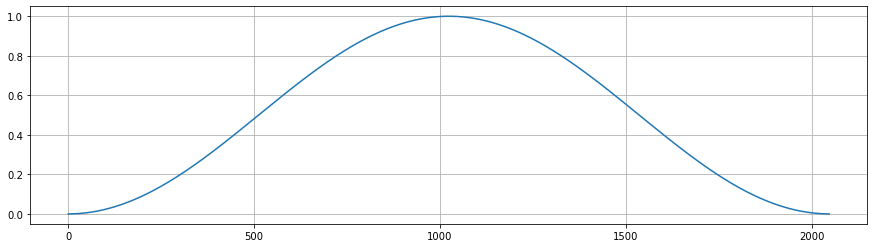

In [10]:
# For simplicity we will choose the Hanning window.
# To make the audio continues, we apply a window function on every frame
# Hann window functions have a sinusoidal shape.
# Hann window touches zero at both ends eliminating all discontinuity
# The window assures that both ends of the signal will end close to zero.
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

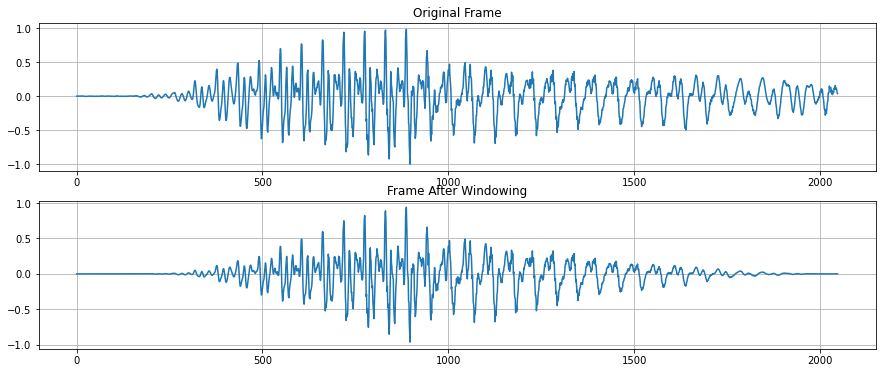

In [11]:
# audio frame window
audio_win = audio_framed * window

ind = 40
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [29]:
# transposing the audio window array to use in the fft
audio_winT = np.transpose(audio_win)

# creating the empty numpy array to hold the audio after fft 
# FFT we only take the the positive part of the spectrum (first half +1)
audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

# calculating the fft and storing in audio_fft
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

# taking the transpose of audio_fft and storing in the same array
audio_fft = np.transpose(audio_fft)

#### Calculate signal power

In [13]:
# calculatomg the audio power
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(80, 1025)


#### MEL-spaced filterbank

In [14]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 4000.0


#### Compute filter points

In [15]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [16]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [17]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 2146.06452750619


array([  0,   6,  13,  22,  32,  44,  59,  76,  97, 121, 151, 185])

#### Construct the filterbank

In [18]:
# filter points that determines the start and stop of the filters. 
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

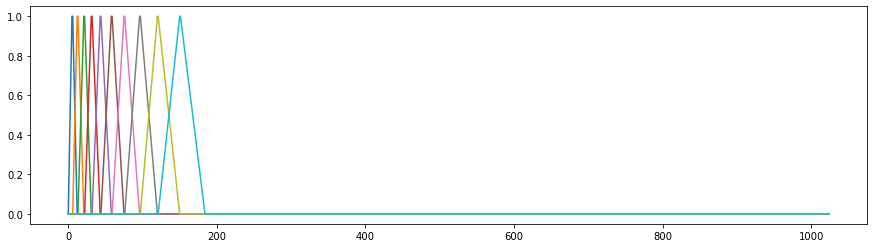

In [19]:
# After we have the filter points, we construct the filters.
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [20]:
# taken from the librosa library
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

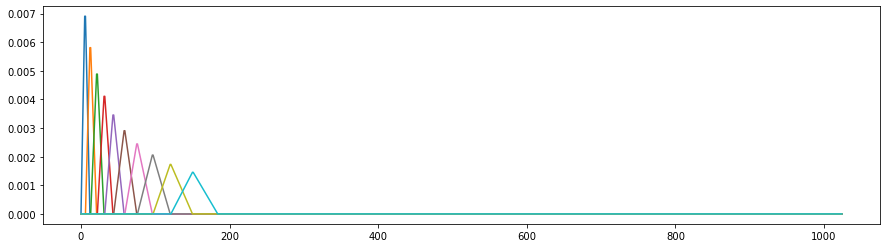

In [21]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

#### Filter the signal

In [22]:
# matrix representing the audio power in all 10 filters in different time frames.
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 80)

#### Generate the Cepstral Coefficents

In [23]:
# generating the MFCC is to use the Discrete Cosine Transform (DCT). 
# we will use the DCT-III. 
# this type of DCT will extract high frequency and low frequency changes in the the signal 
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [24]:
dct_filter_num = 40

# applying dct filter
dct_filters = dct(dct_filter_num, mel_filter_num)

# calculating the cepstral_coefficents (MFCC features)
cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 80)

In [25]:
cepstral_coefficents[:, 0]

array([-7.08096626e+01,  1.62843331e+01, -6.46192607e-02, -1.04038476e+01,
       -1.68537195e+00, -1.80322639e+00,  1.70567633e-01,  4.39729280e+00,
        1.32145584e+00, -3.08000823e+00,  1.14508519e-13,  3.08000823e+00,
       -1.32145584e+00, -4.39729280e+00, -1.70567633e-01,  1.80322639e+00,
        1.68537195e+00,  1.04038476e+01,  6.46192607e-02, -1.62843331e+01,
        1.00139985e+02, -1.62843331e+01,  6.46192607e-02,  1.04038476e+01,
        1.68537195e+00,  1.80322639e+00, -1.70567633e-01, -4.39729280e+00,
       -1.32145584e+00,  3.08000823e+00, -2.01333210e-14, -3.08000823e+00,
        1.32145584e+00,  4.39729280e+00,  1.70567633e-01, -1.80322639e+00,
       -1.68537195e+00, -1.04038476e+01, -6.46192607e-02,  1.62843331e+01])